In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report
from pprint import pprint

torch.manual_seed(0)
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

data_dim = 60 # feature 갯수
hidden_dim = 1536# 은닉층 길이
output_dim = 1 
learning_rate = 0.0001
iterations = 50

trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')

trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

print(trainX_tensor.shape)
print(trainY_tensor.shape)

class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape input for Conv1d
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # Reshape input for LSTM
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        x = torch.sigmoid(x)
        return x

net = CNNLSTM(data_dim, hidden_dim, output_dim, 1).to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
best_loss = float('inf')

for i in tqdm(range(iterations)):
    optimizer.zero_grad()
    outputs = net(trainX_tensor.to(device))
    loss = criterion(outputs, trainY_tensor.to(device))
    loss.backward()
    optimizer.step()





cuda:0
torch.Size([7579, 25, 60])
torch.Size([7579, 1])


100%|██████████| 50/50 [09:29<00:00, 11.39s/it]


In [2]:
testX = np.load('testX.npy')
testY = np.load('testY.npy')
testX = torch.FloatTensor(testX)
testY = torch.FloatTensor(testY)


net.eval()
with torch.no_grad():
    testX_tensor = testX.to(device)
    testY_tensor = testY.to(device)
    outputs = net(testX_tensor)
    predicted_labels = (outputs >= 0.5).float()

classification_report(testY_tensor.cpu(), predicted_labels.cpu())


'              precision    recall  f1-score   support\n\n         0.0       0.81      0.81      0.81       964\n         1.0       0.80      0.81      0.81       931\n\n    accuracy                           0.81      1895\n   macro avg       0.81      0.81      0.81      1895\nweighted avg       0.81      0.81      0.81      1895\n'

In [85]:
testX = np.load('testX.npy')
predic_list = []
net.eval()
for i in range(1,26):
    temp = testX[5:6, 0:i, :]
    testX_tensor = torch.FloatTensor(temp)
    predic = net(testX_tensor.to(device)).item()
    predic_list.append(predic)
print(predic_list)

[0.5888460874557495, 0.5412760972976685, 0.5073779821395874, 0.4612869322299957, 0.4797022044658661, 0.4791077673435211, 0.4722885489463806, 0.40762603282928467, 0.611107349395752, 0.4986432194709778, 0.5606868863105774, 0.5561701655387878, 0.5437532663345337, 0.448738694190979, 0.4835788309574127, 0.5719694495201111, 0.47911909222602844, 0.605109691619873, 0.6175418496131897, 0.4488562345504761, 0.5221079587936401, 0.6187945604324341, 0.617615818977356, 0.6204603910446167, 0.6035985946655273]


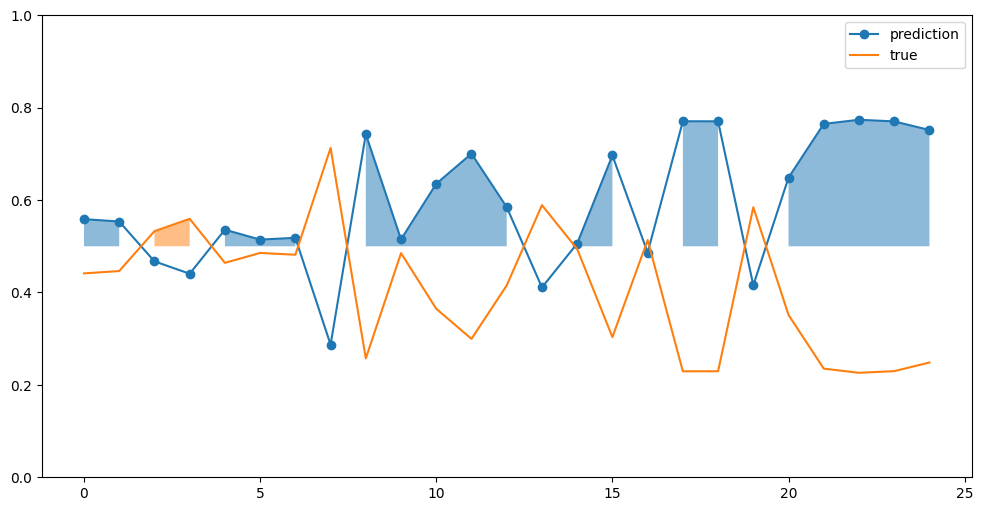

In [140]:

plt.figure(figsize=(12, 6))
plt.plot(range(0, 25), predic_list, 'o-', label='prediction')
plt.plot(range(0, 25), [1 - predic_list[i] for i in range(0, 25)], label='true')

plt.fill_between(range(0, 25), predic_list, [0.5 for i in range(25)], where=[predic_list[p] >= 0.5 for p in range(25)], alpha=0.5)
plt.fill_between(range(0,25), [1-predic_list[i] for i in range(0,25)],[0.5 for i in range(25)],where=[predic_list[p] < 0.5 for p in range(25)] , alpha=0.5)
plt.ylim(0, 1)
plt.legend()
plt.show()


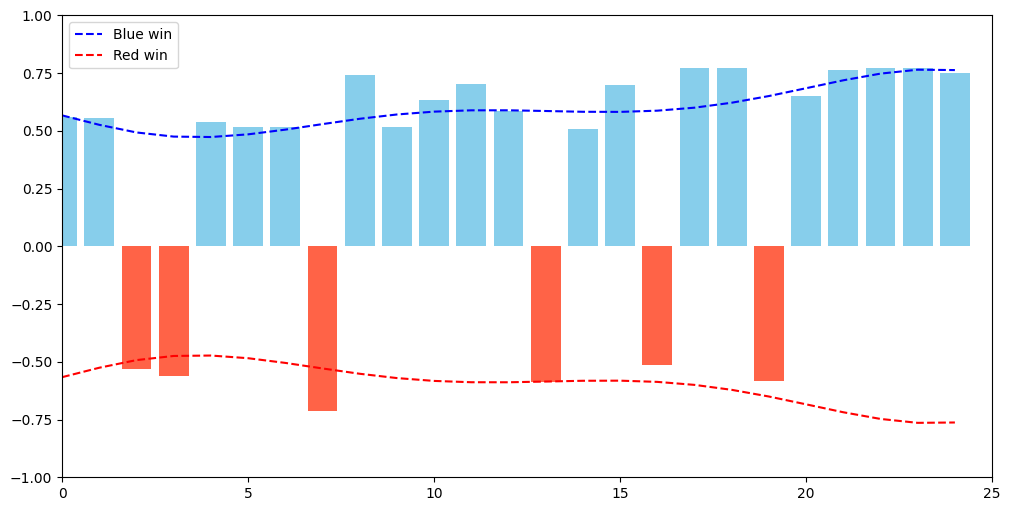

In [125]:
plt.figure(figsize=(12, 6))
red_win = []
blue_win = []
for i in range(0, 25):
    if predic_list[i] >= 0.5:
        blue_win.append(predic_list[i])
        red_win.append(0)
    else:
        red_win.append(-(1 - predic_list[i]))
        blue_win.append(0)

plt.bar(range(0, 25), red_win, color='tomato')
plt.bar(range(0, 25), blue_win, color='skyblue')

# Add trendline
z = np.polyfit(range(0, 25), predic_list, 7)
p = np.poly1d(z)
plt.plot(range(0, 25), p(range(0, 25)), "--", color="blue", label="Blue win")
plt.plot(range(0, 25), -p(range(0, 25)), "--", color="red", label="Red win")
plt.ylim(-1, 1)
plt.xlim(0, 25)
plt.legend()
plt.show()

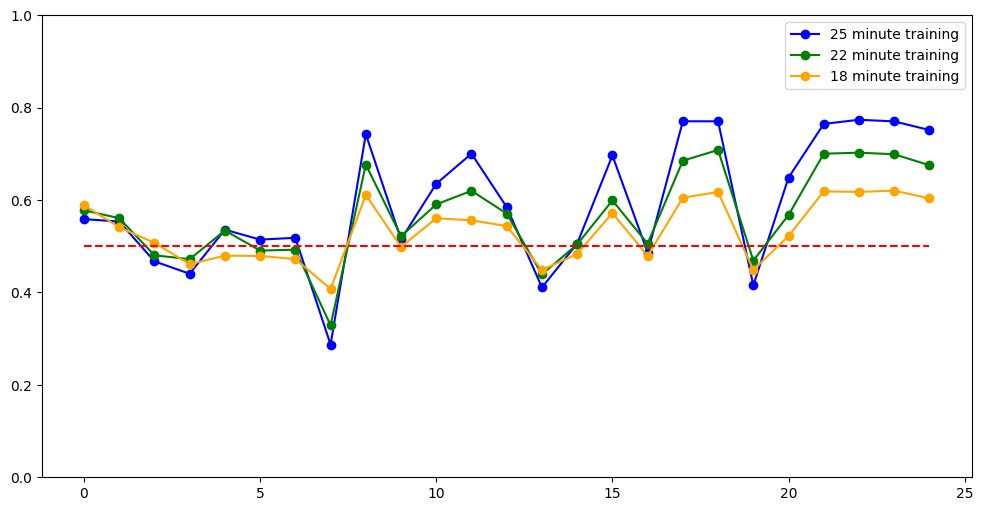

In [93]:
predic_list = [0.5587064623832703, 0.5535992980003357, 0.4673294126987457, 0.4405379891395569, 0.5358856916427612, 0.5144208669662476, 0.518326461315155, 0.2870657444000244, 0.7426916360855103, 0.5148649215698242, 0.6352884769439697, 0.7004665732383728, 0.5846779346466064, 0.41092467308044434, 0.5059071183204651, 0.6966290473937988, 0.48642605543136597, 0.7705733776092529, 0.7704780101776123, 0.4155571460723877, 0.6486474871635437, 0.7648694515228271, 0.7738385796546936, 0.7702920436859131, 0.7516027092933655]
predic_list_22min = [0.5779479742050171, 0.5607353448867798, 0.48050421476364136, 0.47212183475494385, 0.5341185927391052, 0.49073347449302673, 0.49261635541915894, 0.32895851135253906, 0.6768311858177185, 0.521684467792511, 0.5907586812973022, 0.6199873089790344, 0.5708572268486023, 0.4392733573913574, 0.5041168332099915, 0.5991209745407104, 0.5057516694068909, 0.6853174567222595, 0.7084163427352905, 0.4690221846103668, 0.5677818655967712, 0.7003687620162964, 0.7025855183601379, 0.6992130279541016, 0.6753737330436707]
predic_list_18min = [0.5888460874557495, 0.5412760972976685, 0.5073779821395874, 0.4612869322299957, 0.4797022044658661, 0.4791077673435211, 0.4722885489463806, 0.40762603282928467, 0.611107349395752, 0.4986432194709778, 0.5606868863105774, 0.5561701655387878, 0.5437532663345337, 0.448738694190979, 0.4835788309574127, 0.5719694495201111, 0.47911909222602844, 0.605109691619873, 0.6175418496131897, 0.4488562345504761, 0.5221079587936401, 0.6187945604324341, 0.617615818977356, 0.6204603910446167, 0.6035985946655273]
plt.figure(figsize=(12, 6))
plt.plot(range(0,25), predic_list, 'o-', label='25 minute training', color='blue')
plt.plot(range(0,25), predic_list_22min, 'o-', label='22 minute training', color='green')
plt.plot(range(0,25), predic_list_18min, 'o-', label='18 minute training', color='orange')
plt.plot(range(0,25), [0.5 for i in range(25)], '--',color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()